# Part 1: Getting started

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

# os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2023-12-19 10:34:03.043718: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 10:34:03.407501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 10:34:03.409515: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 10:34:05.668704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fetch the jet tagging dataset from Open ML

In [4]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [5]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [7]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [8]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [10]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='glorot_normal', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='glorot_normal', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='glorot_normal', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(32, name='fc4', kernel_initializer='glorot_normal', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu4'))
model.add(Dense(5, name='output', kernel_initializer='glorot_normal', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [11]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=2,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/2
  1/487 [..............................] - ETA: 23:52 - loss: 1.6732 - accuracy: 0.2607WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0049s vs `on_train_batch_end` time: 0.0069s). Check your callbacks.


486/487 [============================>.] - ETA: 0s - loss: 0.9361 - accuracy: 0.6903
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 0.82079, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.82079, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 7s 9ms/step - loss: 0.9360 - accuracy: 0.6904 - val_loss: 0.8208 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 2/2
  1/487 [..............................] - ETA: 4s - loss: 0.7817 - accuracy: 0.7412

/home/georgen24/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


485/487 [============================>.] - ETA: 0s - loss: 0.7921 - accuracy: 0.7438
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 0.82079 to 0.77739, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.82079 to 0.77739, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 2: saving model to model_1/KERAS_check_model_last.h5

Epoch 2: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 8ms/step - loss: 0.7920 - accuracy: 0.7438 - val_loss: 0.7774 - val_accuracy: 0.7471 - lr: 0.0010


## Check performance
Check the accuracy and make a ROC curve

5188/5188 [==============================] - 16s 3ms/step
Accuracy: 0.7456084337349398


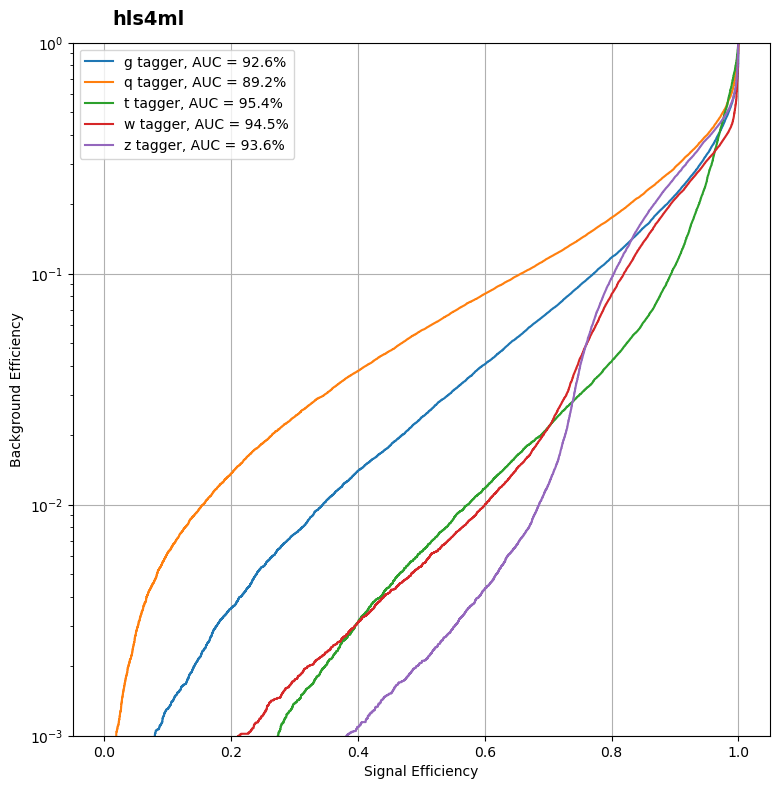

In [13]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

## Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

### Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [ ]:
# import hls4ml

# config = hls4ml.utils.config_from_keras_model(model, granularity='model')
# print("-----------------------------------")
# print("Configuration")
# plotting.print_dict(config)
# print("-----------------------------------")
# hls_model = hls4ml.converters.convert_from_keras_model(
#     model, hls_config=config, output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
# )

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

In [ ]:
# hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [ ]:
# hls_model.compile()
# X_test = np.ascontiguousarray(X_test)
# y_hls = hls_model.predict(X_test)

## Compare
That was easy! Now let's see how the performance compares to Keras:

In [ ]:
# print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
# print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

# fig, ax = plt.subplots(figsize=(9, 9))
# _ = plotting.makeRoc(y_test, y_keras, le.classes_)
# plt.gca().set_prop_cycle(None)  # reset the colors
# _ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

# from matplotlib.lines import Line2D

# lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
# from matplotlib.legend import Legend

# leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
# ax.add_artist(leg)

## Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [ ]:
# hls_model.build(csim=False)

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [ ]:
# hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)